### Load packages

In [2]:
import scanpy as sc
import episcanpy as epi
import numpy as np
import anndata as ad
import random
import copy
import pandas as pd

sc.settings.set_figure_params(dpi=80, color_map='gist_earth')

In [4]:
# to obtain the mouse gene annotation gtf file from gencode
#!wget http://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M23/gencode.vM23.primary_assembly.annotation.gtf.gz
#!gunzip -d gencode.vM23.primary_assembly.annotation.gtf.gz

# Pre-processing 10x
We need to filter the barcodes. 

### Load the 10x windows count matrix

In [6]:
input_dir_10x = '/home/icb/chaichoompu/Group/workspace/data_integration_datasets/10x/merged_peaks_large/'
input_dir_10x = '/home/icb/anna.danese/integration_resubmission/large_peaks/'

adata = ad.read(input_dir_10x+'atac_v1_adult_brain_fresh_5k_fragments_AllCells.h5ad')
adata

AnnData object with n_obs × n_vars = 335609 × 787157

In [7]:
with open('/home/icb/anna.danese/project_anna/integration_benchmarking/resubmission/filtered_peak_bc_matrix/barcodes.tsv') as f:
    barcodes = f.readlines()
    barcodes = [x.rstrip('\n') for x in barcodes]

annot = []
for name in adata.obs_names.tolist():
    if name in barcodes:
        annot.append('keep')
    else:
        annot.append('discard')
adata.obs['filter_barcode_cellranger'] = annot

adata = adata[adata.obs['filter_barcode_cellranger']=='keep',:].copy()
adata

AnnData object with n_obs × n_vars = 3880 × 787157
    obs: 'filter_barcode_cellranger'

In [8]:
# make the matrix binary
print(np.max(adata.X))
epi.pp.binarize(adata)
print(np.max(adata.X))

33.0
1.0


In [9]:
epi.pp.filter_cells(adata, min_features=100)
adata

AnnData object with n_obs × n_vars = 3879 × 787157
    obs: 'filter_barcode_cellranger', 'nb_features'

In [10]:
epi.pp.filter_features(adata, min_cells=10)
adata

AnnData object with n_obs × n_vars = 3879 × 747343
    obs: 'filter_barcode_cellranger', 'nb_features'
    var: 'n_cells'

In [11]:
adata.obs['log_nb_features'] = [np.log10(x) for x in adata.obs['nb_features']]
adata

AnnData object with n_obs × n_vars = 3879 × 747343
    obs: 'filter_barcode_cellranger', 'nb_features', 'log_nb_features'
    var: 'n_cells'

... storing 'filter_barcode_cellranger' as categorical


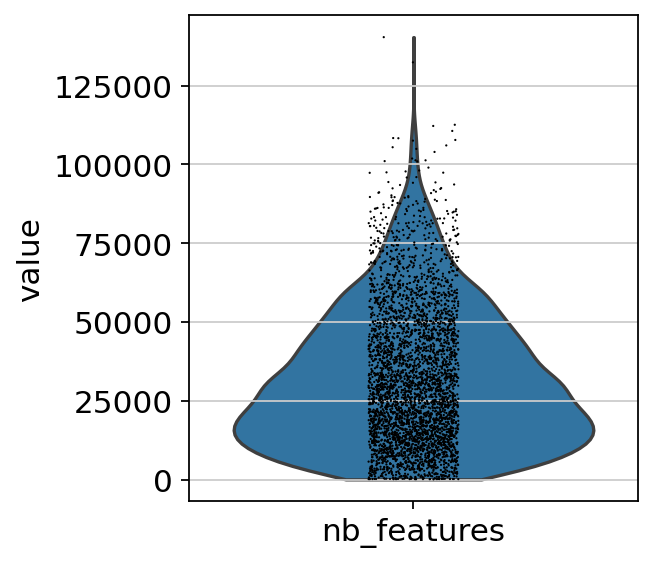

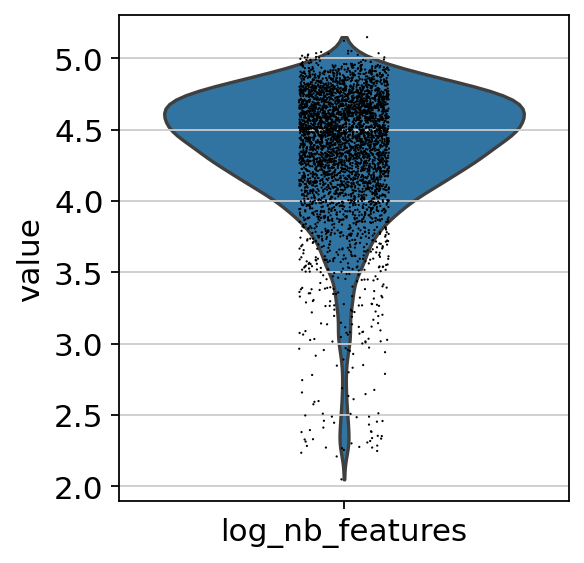

In [12]:
epi.pl.violin(adata, ['nb_features'])
epi.pl.violin(adata, ['log_nb_features'])

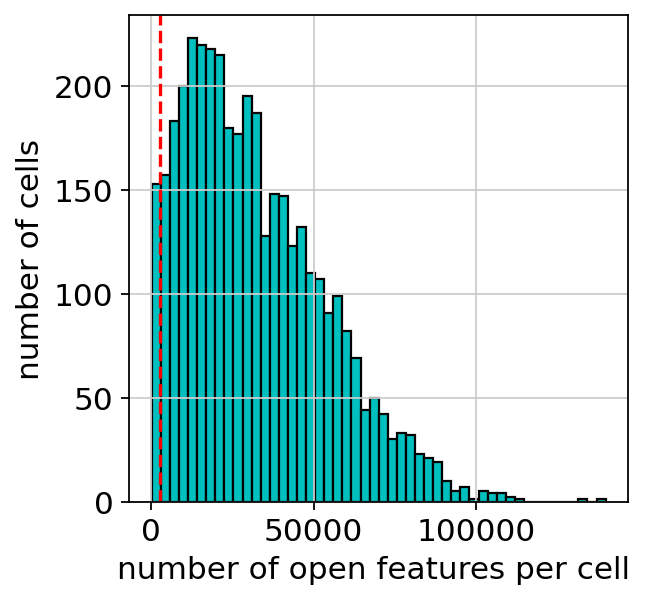

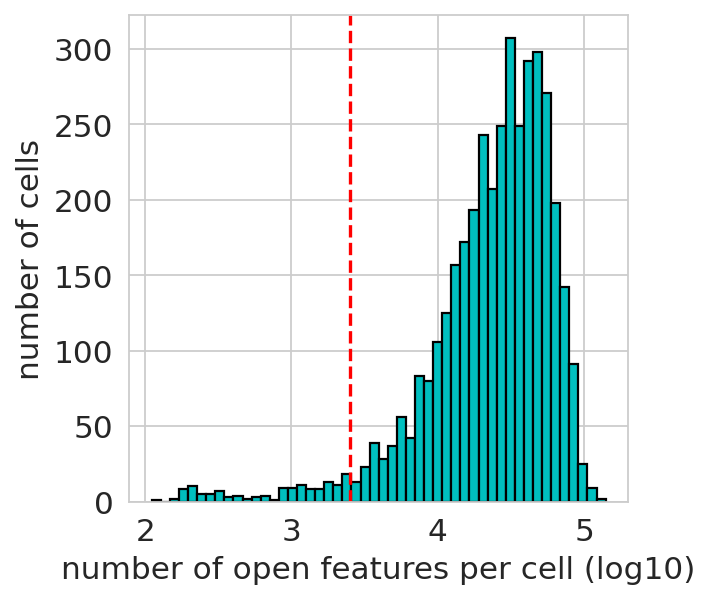

In [13]:
# set a minimum number of cells to keep 
min_features = 2500

epi.pp.coverage_cells(adata, binary=True, log=False, bins=50,
               threshold=min_features, save='10x_large_geneactivity_coverage_cells_200k.png')
epi.pp.coverage_cells(adata, binary=True, log=10, bins=50,
               threshold=min_features, save='10x_large_geneactivity_coverage_cells_log10_200k.png')

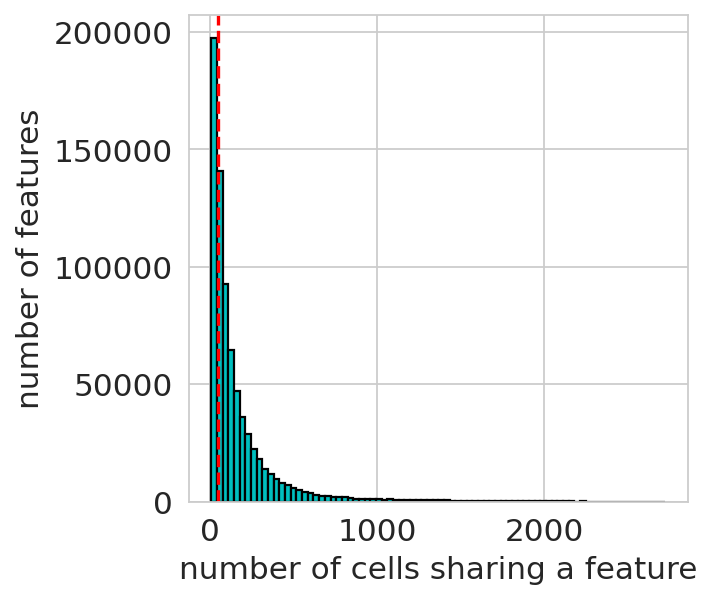

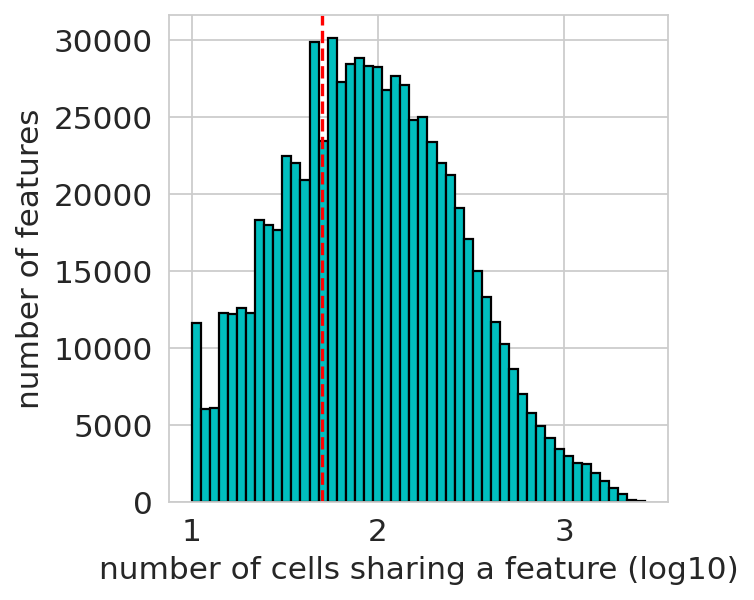

In [14]:
# minimum number of cells sharing a feature
min_cells = 50
epi.pp.coverage_features(adata, binary=True, log=False, 
                        threshold=min_cells, save='10x_large_geneactivity_coverage_200k.png')
epi.pp.coverage_features(adata, binary=True, log=True, 
                        threshold=min_cells, save='10x_large_geneactivity_coverage_log10_200k.png')

In [15]:
min_features = 2500
epi.pp.filter_cells(adata, min_features=min_features)
adata

AnnData object with n_obs × n_vars = 3739 × 747343
    obs: 'filter_barcode_cellranger', 'nb_features', 'log_nb_features'
    var: 'n_cells', 'commonness'

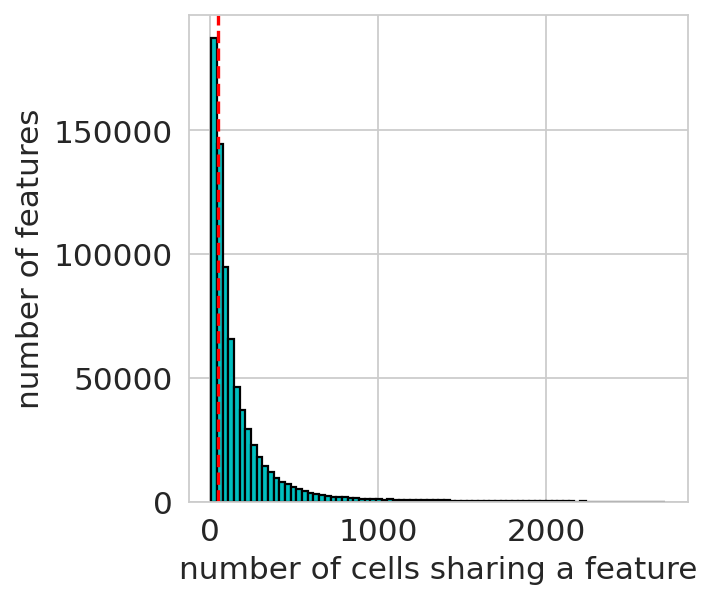

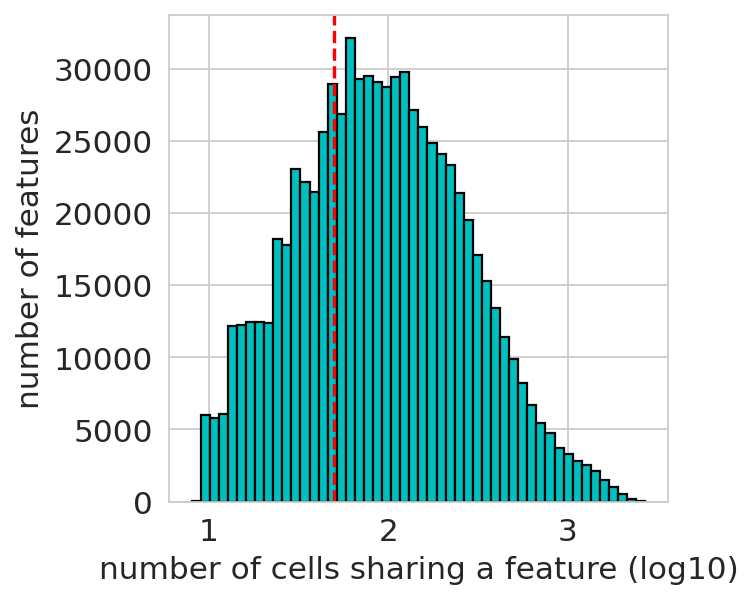

In [16]:
# minimum number of cells sharing a feature
min_cells = 50
epi.pp.coverage_features(adata, binary=True, log=False, 
                        threshold=min_cells, save='10x_large_geneactivity_coverage_200k.png')
epi.pp.coverage_features(adata, binary=True, log=True, 
                        threshold=min_cells, save='10x_large_geneactivity_coverage_log10_200k.png')

In [17]:
min_cells = 50
epi.pp.filter_features(adata, min_cells=min_cells)
adata

AnnData object with n_obs × n_vars = 3739 × 520205
    obs: 'filter_barcode_cellranger', 'nb_features', 'log_nb_features'
    var: 'n_cells', 'commonness'

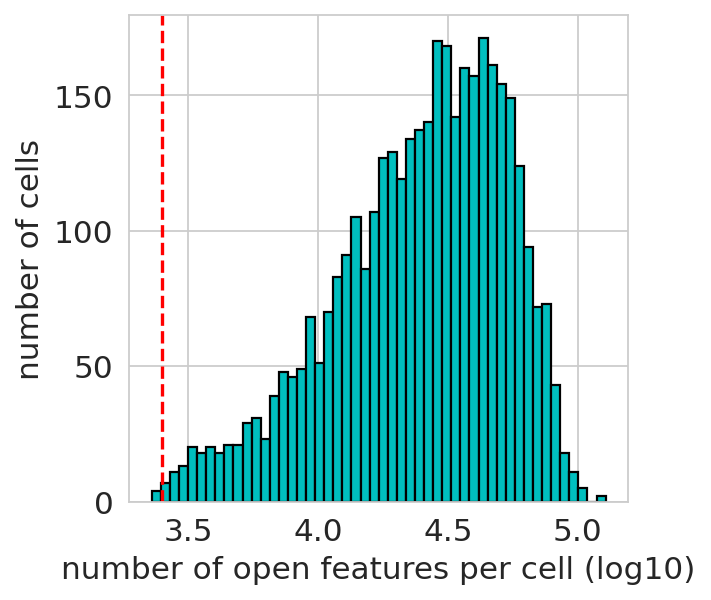

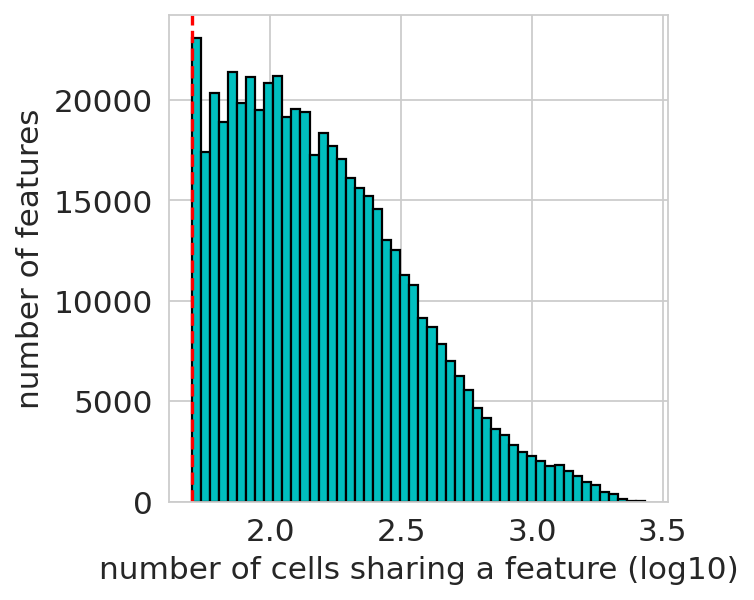

In [18]:
epi.pp.coverage_cells(adata, binary=True, log='log10', bins=50, threshold=min_features)
epi.pp.coverage_features(adata, binary=True, log='log10', bins=50, threshold=min_cells)

In [19]:
adata

AnnData object with n_obs × n_vars = 3739 × 520205
    obs: 'filter_barcode_cellranger', 'nb_features', 'log_nb_features'
    var: 'n_cells', 'commonness'

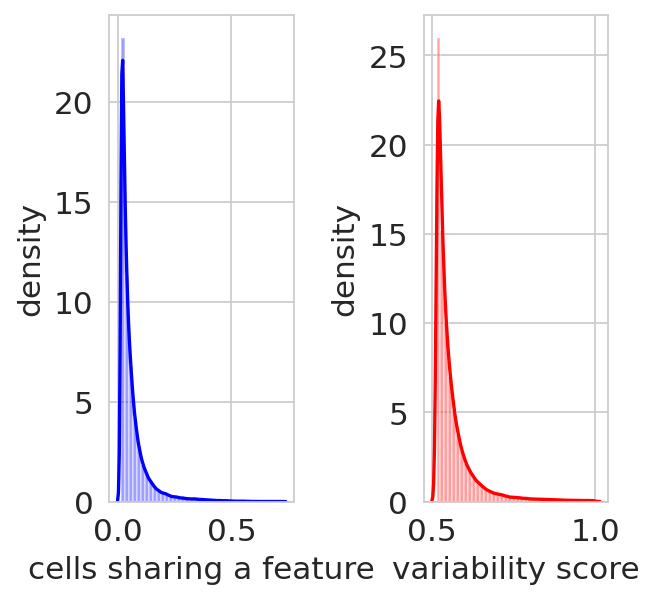

In [20]:
epi.pp.cal_var(adata)

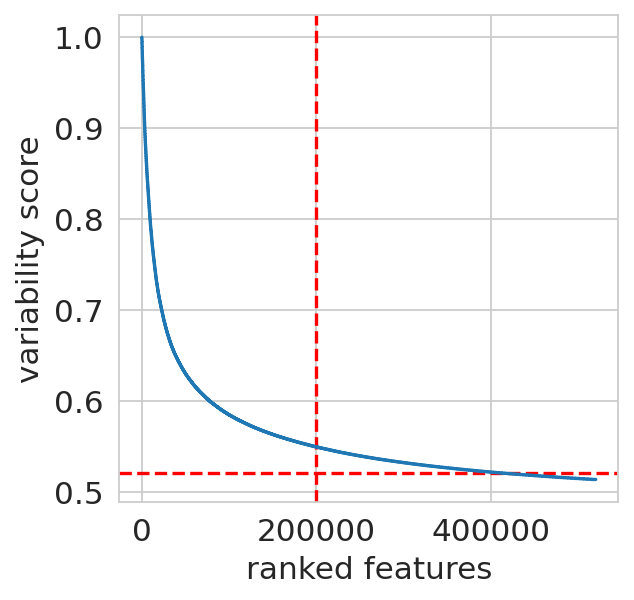

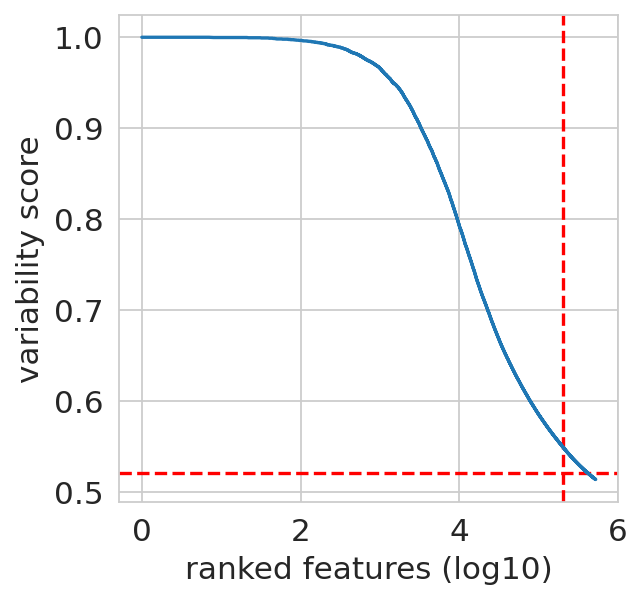

In [21]:
min_score_value = 0.52
nb_feature_selected = 200000
epi.pl.variability_features(adata,log=None,
                     min_score=min_score_value, nb_features=nb_feature_selected,
                     save='variability_features_plot_10x_large_peaks_200k.png')

epi.pl.variability_features(adata,log='log10',
                     min_score=min_score_value, nb_features=nb_feature_selected,
                     save='variability_features_plot_10x_large_peaks_log10_200k.png')

In [22]:
# save the current matrix in the raw layer
adata.raw = adata

In [23]:
nb_feature_selected = 200000
# create a new AnnData containing only the most variable features
adata = epi.pp.select_var_feature(adata,
                                  nb_features=nb_feature_selected,
                                  show=False,
                                  copy=True)

In [24]:
adata

View of AnnData object with n_obs × n_vars = 3739 × 200430
    obs: 'filter_barcode_cellranger', 'nb_features', 'log_nb_features'
    var: 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'

In [ ]:
adata10x = epi.tl.geneactivity(adata, gtf_file='gencode.vM23.primary_assembly.annotation.gtf',
                      feature_type='transcript',
                     upstream=5000)

In [ ]:
adata10x.write('./integration_resubmission/gene_activity_10x_large_200k_transcripts.h5ad')

# large Fang

In [ ]:
input_dir_fang = './integration_resubmission/large_peaks/'

adata2 = ad.read(input_dir_fang+'CEMBA180305_2B_AllCells.h5ad')


adata2

In [ ]:
adata3 = ad.read(input_dir_fang+'CEMBA180306_2B_AllCells.h5ad')
adata3

adata2 = adata2.concatenate(adata3)

batchname=copy.copy(adata2.obs['batch'])
batchname

batchname = batchname.map({ '1' : 'CEMBA180306_2B', '0' : 'CEMBA180305_2B' })
batchname

adata2.obs['batchname_Fang'] = batchname
adata2

In [ ]:
adata3 = ad.read(input_dir_fang+'CEMBA180226_1A_AllCells.h5ad')
adata2 = adata2.concatenate(adata3)
adata2.obs['batchname_Fang'] = adata2.obs['batchname_Fang'].replace(np.nan, 'CEMBA180226_1A', regex=False)
adata2

In [ ]:
adata3 = ad.read(input_dir_fang+'CEMBA180227_1A_AllCells.h5ad')
adata2 = adata2.concatenate(adata3)
adata2.obs['batchname_Fang'] = adata2.obs['batchname_Fang'].replace(np.nan, 'CEMBA180227_1A', regex=False)
adata2

In [ ]:
adata3 = ad.read(input_dir_fang+'CEMBA180308_3B_AllCells.h5ad')
adata2 = adata2.concatenate(adata3)
adata2.obs['batchname_Fang'] = adata2.obs['batchname_Fang'].replace(np.nan, 'CEMBA180308_3B', regex=False)
adata2

In [ ]:
adata3 = ad.read(input_dir_fang+'CEMBA180312_3B_AllCells.h5ad')
adata2 = adata2.concatenate(adata3)
adata2.obs['batchname_Fang'] = adata2.obs['batchname_Fang'].replace(np.nan, 'CEMBA180312_3B', regex=False)
adata2

In [ ]:
print(np.max(adata2.X))
epi.pp.binarize(adata2)
print(np.max(adata2.X))

In [ ]:
epi.pp.filter_cells(adata2, min_features=100)
adata2

In [ ]:
epi.pp.filter_features(adata2, min_cells=10)
adata2

In [ ]:
adata2.obs['log_nb_features'] = [np.log10(x) for x in adata2.obs['nb_features']]
adata2

In [ ]:
epi.pl.violin(adata2, ['nb_features'])
epi.pl.violin(adata2, ['log_nb_features'])

In [ ]:
# set a minimum number of cells to keep 
min_features = 1000

epi.pp.coverage_cells(adata2, binary=True, log=False, bins=50,
               threshold=min_features, save='CEMBA180305_2B_geneactivity_large_coverage_cells_200k.png')
epi.pp.coverage_cells(adata2, binary=True, log=10, bins=50,
               threshold=min_features, save='CEMBA180305_2B_geneactivity_large_coverage_cells_log10_200k.png')

In [ ]:
# minimum number of cells sharing a feature
min_cells = 25
epi.pp.coverage_features(adata2, binary=True, log=False, 
                        threshold=min_cells, save='CEMBA180305_2B_geneactivity_large_coverage_200k.png')
epi.pp.coverage_features(adata2, binary=True, log=True, 
                        threshold=min_cells, save='CEMBA180305_2B_geneactivity_large_coverage_log10_200k.png')

In [ ]:
min_features = 1000
epi.pp.filter_cells(adata2, min_features=min_features)

In [ ]:
epi.pp.filter_features(adata2, min_cells=25)
adata2

In [ ]:
epi.pp.cal_var(adata2)

In [ ]:
min_score_value = 0.52
nb_feature_selected = 200000
epi.pl.variability_features(adata2,log=None,
                     min_score=min_score_value, nb_features=nb_feature_selected,
                     save='variability_features_plot_CEMBA180305_2B_geneactivity_large_200k.png')

epi.pl.variability_features(adata2,log='log10',
                     min_score=min_score_value, nb_features=nb_feature_selected,
                     save='variability_features_plot_CEMBA180305_2B_geneactivity_large_log10_200k.png')

In [ ]:
# save the current matrix in the raw layer
adata2.raw = adata2

In [ ]:
# create a new AnnData containing only the most variable features
adata2 = epi.pp.select_var_feature(adata2,
                                  nb_features=nb_feature_selected,
                                  show=False,
                                  copy=True)

In [ ]:
epi.pl.violin(adata2, ['nb_features'])
epi.pl.violin(adata2, ['log_nb_features'])

In [ ]:
adatafang = geneactivity(adata2, gtf_file='gencode.vM23.primary_assembly.annotation.gtf',
                      feature_type='transcript', 
                     upstream=5000)

In [ ]:
adatafang.write('./integration_resubmission/gene_activity_fang_large_200k_transcripts.h5ad')

# Cusanovich small

In [ ]:
input_dir_Cusanovich = './integration_resubmission/large_peaks/'

In [ ]:
adatacus1 = ad.read(input_dir_Cusanovich+'SRR6819246_AllCells.h5ad')
adatacus1

adatacus2 = ad.read(input_dir_Cusanovich+'SRR6819247_AllCells.h5ad')
adatacus2

## First I will add the barcodes present in the 2 files
barcodes1 = adatacus1.obs_names.tolist()
barcodes2 = adatacus2.obs_names.tolist()

annot = []
for line in barcodes1:
    if line in barcodes2:
        annot.append('keep')
    else:
        annot.append('discard')
adatacus1.obs['filter'] = annot

annot = []
for line in barcodes2:
    if line in barcodes1:
        annot.append('keep')
    else:
        annot.append('discard')
adatacus2.obs['filter'] = annot


adatacus1 = adatacus1[adatacus1.obs['filter']=='keep',:].copy()
adatacus1

adatacus2 = adatacus2[adatacus2.obs['filter']=='keep',:].copy()
adatacus2


adata3 = adatacus1.copy()
adata3.X = adata3.X+adatacus2.X


del adata3.obs['filter'], adatacus1, adatacus2

adata3

In [ ]:
adatacus1 = ad.read(input_dir_Cusanovich+'SRR6819248_AllCells.h5ad')
adatacus1

adatacus2 = ad.read(input_dir_Cusanovich+'SRR6819249_AllCells.h5ad')
adatacus2

## First I will add the barcodes present in the 2 files
barcodes1 = adatacus1.obs_names.tolist()
barcodes2 = adatacus2.obs_names.tolist()

annot = []
for line in barcodes1:
    if line in barcodes2:
        annot.append('keep')
    else:
        annot.append('discard')
adatacus1.obs['filter'] = annot

annot = []
for line in barcodes2:
    if line in barcodes1:
        annot.append('keep')
    else:
        annot.append('discard')
adatacus2.obs['filter'] = annot


adatacus1 = adatacus1[adatacus1.obs['filter']=='keep',:].copy()
adatacus1

adatacus2 = adatacus2[adatacus2.obs['filter']=='keep',:].copy()
adatacus2


adatatmp = adatacus1.copy()
adatatmp.X = adatatmp.X+adatacus2.X


del adatatmp.obs['filter'], adatacus1, adatacus2




adata3 = adata3.concatenate(adatatmp)

batchname=copy.copy(adata3.obs['batch'])
batchname

batchname = batchname.map({ '1' : 'WholeBrainA_62816', '0' : 'WholeBrainA_62216' })
batchname

adata3.obs['batchname_Cusanovich'] = batchname
adata3.obs['batchname'] = batchname
adata3

In [ ]:
adatacus1 = ad.read(input_dir_Cusanovich+'SRR6819238_AllCells.h5ad')
adatacus1

adatacus2 = ad.read(input_dir_Cusanovich+'SRR6819239_AllCells.h5ad')
adatacus2

## First I will add the barcodes present in the 2 files
barcodes1 = adatacus1.obs_names.tolist()
barcodes2 = adatacus2.obs_names.tolist()

annot = []
for line in barcodes1:
    if line in barcodes2:
        annot.append('keep')
    else:
        annot.append('discard')
adatacus1.obs['filter'] = annot

annot = []
for line in barcodes2:
    if line in barcodes1:
        annot.append('keep')
    else:
        annot.append('discard')
adatacus2.obs['filter'] = annot


adatacus1 = adatacus1[adatacus1.obs['filter']=='keep',:].copy()
adatacus1

adatacus2 = adatacus2[adatacus2.obs['filter']=='keep',:].copy()
adatacus2


adatatmp = adatacus1.copy()
adatatmp.X = adatatmp.X+adatacus2.X


del adatatmp.obs['filter'], adatacus1, adatacus2


adata3 = adata3.concatenate(adatatmp)

batchname=copy.copy(adata3.obs['batch'])
batchname

adata3.obs['batchname_Cusanovich'] = adata3.obs['batchname_Cusanovich'].replace(np.nan, 'PreFrontalCortex_62216', regex=False)
adata3.obs['batchname'] = adata3.obs['batchname'].replace(np.nan, 'PreFrontalCortex_62216', regex=False)



In [ ]:
adatacus1 = ad.read(input_dir_Cusanovich+'SRR6819220_AllCells.h5ad')
adatacus1

adatacus2 = ad.read(input_dir_Cusanovich+'SRR6819221_AllCells.h5ad')
adatacus2

## First I will add the barcodes present in the 2 files
barcodes1 = adatacus1.obs_names.tolist()
barcodes2 = adatacus2.obs_names.tolist()

annot = []
for line in barcodes1:
    if line in barcodes2:
        annot.append('keep')
    else:
        annot.append('discard')
adatacus1.obs['filter'] = annot

annot = []
for line in barcodes2:
    if line in barcodes1:
        annot.append('keep')
    else:
        annot.append('discard')
adatacus2.obs['filter'] = annot


adatacus1 = adatacus1[adatacus1.obs['filter']=='keep',:].copy()
adatacus1

adatacus2 = adatacus2[adatacus2.obs['filter']=='keep',:].copy()
adatacus2


adatatmp = adatacus1.copy()
adatatmp.X = adatatmp.X+adatacus2.X


del adatatmp.obs['filter'], adatacus1, adatacus2


adata3 = adata3.concatenate(adatatmp)

batchname=copy.copy(adata3.obs['batch'])
batchname

adata3.obs['batchname_Cusanovich'] = adata3.obs['batchname_Cusanovich'].replace(np.nan, 'Cerebellum_62216', regex=False)
adata3.obs['batchname'] = adata3.obs['batchname'].replace(np.nan, 'Cerebellum_62216', regex=False)

adata3

In [ ]:
print(np.max(adata3.X))
epi.pp.binarize(adata3)
print(np.max(adata3.X))

In [ ]:
# remove any potential empty features or barcodes
epi.pp.filter_cells(adata3, min_features=1)
epi.pp.filter_features(adata3, min_cells=1)
adata3

In [ ]:
# set a minimum number of cells to keep 
min_features = 1000

epi.pp.coverage_cells(adata3, binary=True, log=False, bins=50,
               threshold=min_features, save='Cusanovich_coverage_cells_geneactivity_large_200k.png')
epi.pp.coverage_cells(adata3, binary=True, log=10, bins=50,
               threshold=min_features, save='Cusanovich_coverage_cells_geneactivity_large_log10_200k.png')

In [ ]:
# minimum number of cells sharing a feature
min_cells = 10
epi.pp.coverage_features(adata3, binary=True, log=False, 
                        threshold=min_cells)
epi.pp.coverage_features(adata3, binary=True, log=True, 
                        threshold=min_cells)

In [ ]:
min_features = 1000
epi.pp.filter_cells(adata3, min_features=min_features)

In [ ]:
min_cells = 10
epi.pp.filter_features(adata3, min_cells=min_cells)

In [ ]:
epi.pp.coverage_cells(adata3, binary=True, log='log10', bins=50, threshold=min_features)
epi.pp.coverage_features(adata3, binary=True, log='log10', bins=50, threshold=min_cells)


In [ ]:
epi.pp.cal_var(adata3)

In [ ]:
min_score_value = 0.54
epi.pl.variability_features(adata3,log=None,
                     min_score=min_score_value, nb_features=nb_feature_selected)

epi.pl.variability_features(adata3,log='log10',
                     min_score=min_score_value, nb_features=nb_feature_selected)

In [ ]:
# save the current matrix in the raw layer
adata3.raw = adata3

In [ ]:
# create a new AnnData containing only the most variable features
adata3 = epi.pp.select_var_feature(adata3,
                            nb_features=nb_feature_selected,
                            show=False,
                            copy=True)

In [ ]:
# save the current version of the matrix (binary, not normalised) in a layer of the Anndata.
adata3.layers['counts'] = adata3.X.copy()

In [ ]:
adata3

In [ ]:
adatacus = geneactivity(adata3, gtf_file='gencode.vM23.primary_assembly.annotation.gtf',
                        feature_type='transcript',
                       upstream=5000)

In [ ]:
adatacus.write('./integration_resubmission/gene_activity_cus_large_200k_transcripts.h5ad')